In [113]:
# credit : https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/blob/master/Siamese-networks-medium.ipynb
# credit : https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e
# credit : https://github.com/InsuJeon/HelloPyTorch/blob/master/06_Batch_Training.ipynb

# Siamese Networks
Siamese networks are a special type of neural network architecture. Instead of a model learning to classify its inputs, the neural networks learns to differentiate between two inputs. It learns the similarity between them.

# The architecture

A Siamese networks consists of two identical neural networks, each taking one of the two input images. The last layers of the two networks are then fed to a contrastive loss function , which calculates the similarity between the two images

<img src="siamese.png" width="400">

There are two sister networks, which are identical neural networks, with the exact same weights.
Each image in the image pair is fed to one of these networks.

# Contrastive Loss function
The objective of the siamese architecture is not to classify input images, but to differentiate between them. So, a classification loss function (such as cross entropy) would not be the best fit. Instead, this architecture is better suited to use a contrastive function. Intuitively, this function just evaluates how well the network is distinguishing a given pair of images.

<img src="eq1.png" width="700">

where Dw is defined as the euclidean distance between the outputs of the sister siamese networks. Mathematically the euclidean distance is :

<img src="eq2.png" width="350">

where Gw is the output of one of the sister networks. X1 and X2 is the input data pair.

# Equation Explanation
__Y__ is either 1 or 0. If the inputs are from the same class , then the value of __Y__ is 0 , otherwise __Y__ is 1

__max()__ is a function denoting the bigger value between 0 and m-Dw.

__m__ is a margin value which is greater than 0. Having a margin indicates that dissimilar pairs that are beyond this margin will not contribute to the loss. 



# Imports
All the imports are defined here

In [157]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# torchvision
The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.

https://pytorch.org/docs/stable/torchvision/index.html

# Helper functions
Set of helper functions

In [158]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    
class Resize(object):
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation
    def __call__(self, img):
        return img.resize(self.size, resample=self.interpolation)

# Configuration Class
A simple class to manage configuration

In [159]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 30

# Using Image Folder 
<img src="imgfolder.png" width="600">

In [160]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

Input pipeline from a folder containing multiple folders of images
we can check the classes, class_to_idx, and filename with idx

In [161]:
vars(folder_dataset)

{'root': './data/faces/training/',
 'loader': <function torchvision.datasets.folder.default_loader(path)>,
 'extensions': ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif'],
 'classes': ['s1',
  's10',
  's11',
  's12',
  's13',
  's14',
  's15',
  's16',
  's17',
  's18',
  's19',
  's2',
  's20',
  's21',
  's22',
  's23',
  's24',
  's25',
  's26',
  's27',
  's28',
  's29',
  's3',
  's30',
  's31',
  's32',
  's33',
  's34',
  's35',
  's36',
  's37',
  's38',
  's39',
  's4',
  's40',
  's8',
  's9'],
 'class_to_idx': {'s1': 0,
  's10': 1,
  's11': 2,
  's12': 3,
  's13': 4,
  's14': 5,
  's15': 6,
  's16': 7,
  's17': 8,
  's18': 9,
  's19': 10,
  's2': 11,
  's20': 12,
  's21': 13,
  's22': 14,
  's23': 15,
  's24': 16,
  's25': 17,
  's26': 18,
  's27': 19,
  's28': 20,
  's29': 21,
  's3': 22,
  's30': 23,
  's31': 24,
  's32': 25,
  's33': 26,
  's34': 27,
  's35': 28,
  's36': 29,
  's37': 30,
  's38': 31,
  's39': 32,
  's4': 33,
  's40': 34,
  's8': 35,
  's9': 36}

In [162]:
folder_dataset.imgs

[('./data/faces/training/s1/1.pgm.png', 0),
 ('./data/faces/training/s1/10.pgm.png', 0),
 ('./data/faces/training/s1/2.pgm.png', 0),
 ('./data/faces/training/s1/3.pgm.png', 0),
 ('./data/faces/training/s1/4.pgm.png', 0),
 ('./data/faces/training/s1/5.pgm.png', 0),
 ('./data/faces/training/s1/6.pgm.png', 0),
 ('./data/faces/training/s1/7.pgm.png', 0),
 ('./data/faces/training/s1/8.pgm.png', 0),
 ('./data/faces/training/s1/9.pgm.png', 0),
 ('./data/faces/training/s10/1.pgm.png', 1),
 ('./data/faces/training/s10/10.pgm.png', 1),
 ('./data/faces/training/s10/2.pgm.png', 1),
 ('./data/faces/training/s10/3.pgm.png', 1),
 ('./data/faces/training/s10/4.pgm.png', 1),
 ('./data/faces/training/s10/5.pgm.png', 1),
 ('./data/faces/training/s10/6.pgm.png', 1),
 ('./data/faces/training/s10/7.pgm.png', 1),
 ('./data/faces/training/s10/8.pgm.png', 1),
 ('./data/faces/training/s10/9.pgm.png', 1),
 ('./data/faces/training/s11/1.pgm.png', 2),
 ('./data/faces/training/s11/10.pgm.png', 2),
 ('./data/faces/t

# Define Custom Dataset 
Your custom dataset should inherit Dataset and override the following methods:

__len__ so that len(dataset) returns the size of the dataset

__getitem__ to support the indexing such that dataset[i] can be used to get ith sample

In [163]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break           
                    
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        # Converting a greyscale (“L”)
        img0 = img0.convert("L") 
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [164]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]))

# Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image. 1 indiciates dissimilar, and 0 indicates similar.

__DataLoader__ (= 전체 Data를 쪼개서 Batch Size 단위로 불러 오는 역할)

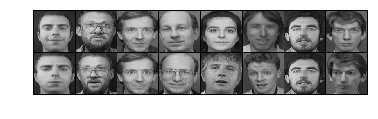

[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]]


In [165]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
# When iteration starts, queue and thread start to load dataset from files.
dataiter = iter(vis_dataloader)
# Mini-batch images and labels.
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

# Neural Net Definition

In [166]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
      
        self.fc = nn.Sequential(
            nn.Linear(100*100, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 5))

    def forward_once(self, x):
        output = x.view(-1,100*100)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Contrastive Loss

In [167]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

# Training Time!

In [168]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=Config.train_batch_size)


In [169]:
net = SiameseNetwork()#.cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005)

In [170]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.8214237689971924

Epoch number 1
 Current loss 1.3281867504119873

Epoch number 2
 Current loss 1.205873727798462

Epoch number 3
 Current loss 1.2632286548614502

Epoch number 4
 Current loss 1.1126348972320557

Epoch number 5
 Current loss 1.1493383646011353

Epoch number 6
 Current loss 1.2277202606201172

Epoch number 7
 Current loss 1.2645809650421143

Epoch number 8
 Current loss 1.1470082998275757

Epoch number 9
 Current loss 1.1273022890090942

Epoch number 10
 Current loss 1.230884075164795

Epoch number 11
 Current loss 1.1835362911224365

Epoch number 12
 Current loss 1.1530141830444336

Epoch number 13
 Current loss 1.1446003913879395

Epoch number 14
 Current loss 1.2039836645126343

Epoch number 15
 Current loss 1.1369887590408325

Epoch number 16
 Current loss 1.126044750213623

Epoch number 17
 Current loss 1.2254266738891602

Epoch number 18
 Current loss 1.1328177452087402

Epoch number 19
 Current loss 1.1280889511108398

Epoch number 

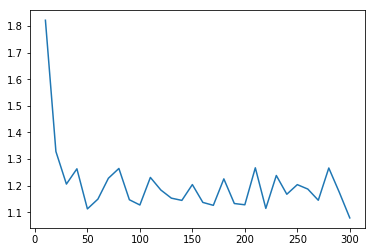

In [171]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        #img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

# Some simple testing
The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

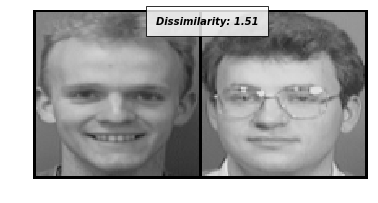

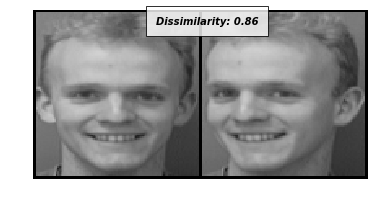

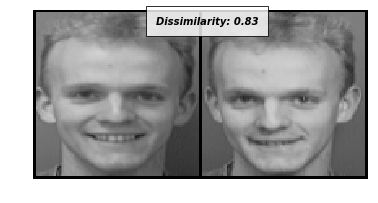

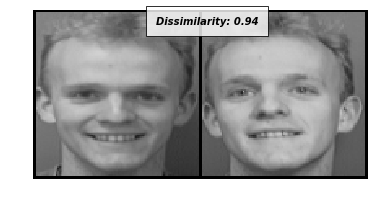

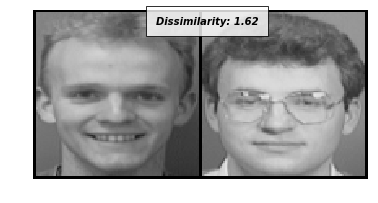

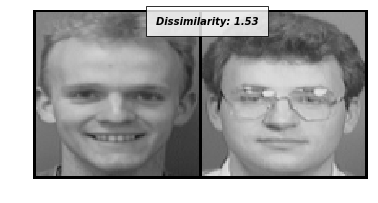

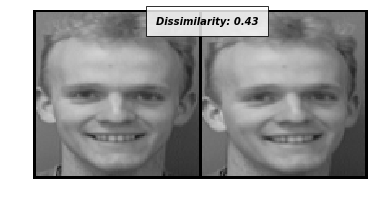

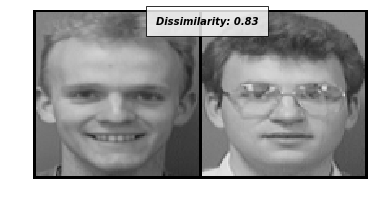

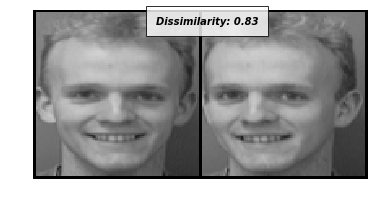

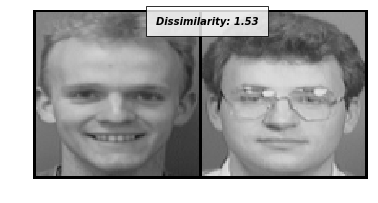

In [172]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]))

test_dataloader = DataLoader(siamese_dataset,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)

    output1,output2 = net(Variable(x0),Variable(x1))
    #output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))